# Face Generation
This is a modification of the face generation project found on udacity's Deep Learning course. The project will be to generate faces but, this time using self-normalizing units instead of batch normalization.

### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex I test the GAN on MNIST before CelebA. This should allow me to see how the model trains sooner.


In [18]:
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

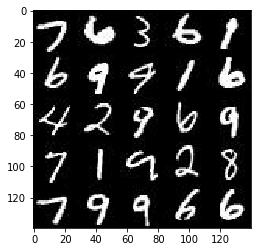

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
import pickle as pkl
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

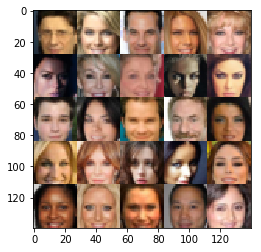

In [20]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import numpy as np

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


# SELU Implementation 

SELU Implementation based on the the ipynb
https://github.com/bioinf-jku/SNNs/blob/master/getSELUparameters.ipynb


In [22]:
from scipy.special import erf,erfc
from sympy import Symbol, solve, nsolve


In [23]:
from __future__ import absolute_import, division, print_function
import numbers
from tensorflow.contrib import layers
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.layers import utils

In [24]:
def getSeluParameters(fixedpointMean=0,fixedpointVar=1):
    """ Finding the parameters of the SELU activation function. The function returns alpha and lambda for the desired fixed point. """
    
    import sympy
    from sympy import Symbol, solve, nsolve

    aa = Symbol('aa')
    ll = Symbol('ll')
    nu = fixedpointMean 
    tau = fixedpointVar 

    mean =  0.5*ll*(nu + np.exp(-nu**2/(2*tau))*np.sqrt(2/np.pi)*np.sqrt(tau) + \
                        nu*erf(nu/(np.sqrt(2*tau))) - aa*erfc(nu/(np.sqrt(2*tau))) + \
                        np.exp(nu+tau/2)*aa*erfc((nu+tau)/(np.sqrt(2*tau))))

    var = 0.5*ll**2*(np.exp(-nu**2/(2*tau))*np.sqrt(2/np.pi*tau)*nu + (nu**2+tau)* \
                          (1+erf(nu/(np.sqrt(2*tau)))) + aa**2 *erfc(nu/(np.sqrt(2*tau))) \
                          - aa**2 * 2 *np.exp(nu+tau/2)*erfc((nu+tau)/(np.sqrt(2*tau)))+ \
                          aa**2*np.exp(2*(nu+tau))*erfc((nu+2*tau)/(np.sqrt(2*tau))) ) - mean**2

    eq1 = mean - nu
    eq2 = var - tau

    res = nsolve( (eq2, eq1), (aa,ll), (1.67,1.05))
    return float(res[0]),float(res[1])

In [26]:
### To recover the parameters of the SELU with mean zero and unit variance
getSeluParameters(0,1)
## To obtain new parameters for mean zero and variance 2
myFixedPointMean = 0
myFixedPointVar = 1.0
myAlpha, myLambda = getSeluParameters(myFixedPointMean,myFixedPointVar)
getSeluParameters(myFixedPointMean,myFixedPointVar)

(1.6732632423543778, 1.0507009873554802)

In [27]:
def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = myAlpha
        scale = myLambda
        return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x))

def dropout_selu(x, rate, alpha= -myAlpha*myLambda, fixedPointMean=myFixedPointMean, fixedPointVar=myFixedPointVar, 
                 noise_shape=None, seed=None, name=None, training=False):
    """Dropout to a value with rescaling."""

    def dropout_selu_impl(x, rate, alpha, noise_shape, seed, name):
        keep_prob = 1.0 - rate
        x = ops.convert_to_tensor(x, name="x")
        if isinstance(keep_prob, numbers.Real) and not 0 < keep_prob <= 1:
            raise ValueError("keep_prob must be a scalar tensor or a float in the "
                                             "range (0, 1], got %g" % keep_prob)
        keep_prob = ops.convert_to_tensor(keep_prob, dtype=x.dtype, name="keep_prob")
        keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

        alpha = ops.convert_to_tensor(alpha, dtype=x.dtype, name="alpha")
        keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

        if tensor_util.constant_value(keep_prob) == 1:
            return x

        noise_shape = noise_shape if noise_shape is not None else array_ops.shape(x)
        random_tensor = keep_prob
        random_tensor += random_ops.random_uniform(noise_shape, seed=seed, dtype=x.dtype)
        binary_tensor = math_ops.floor(random_tensor)
        ret = x * binary_tensor + alpha * (1-binary_tensor)


        a = tf.sqrt(fixedPointVar / (keep_prob *((1-keep_prob) * tf.pow(alpha-fixedPointMean,2) + fixedPointVar)))
        
        b = fixedPointMean - a * (keep_prob * fixedPointMean + (1 - keep_prob) * alpha)
        ret = a * ret + b
        ret.set_shape(x.get_shape())
        return ret

    with ops.name_scope(name, "dropout", [x]) as name:
        return utils.smart_cond(training,
            lambda: dropout_selu_impl(x, rate, alpha, noise_shape, seed, name),
            lambda: array_ops.identity(x))

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [28]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(dtype=tf.float32, 
                                 shape=(None, image_width, image_height, image_channels),
                                 name='real_images')
    
    z_input = tf.placeholder(dtype=tf.float32,
                             shape=(None, z_dim),
                             name='z_input')
    
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    
    drop_prob = tf.placeholder(dtype=tf.float32, name='drop_prob')

    return real_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [29]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    drop_rate=0.1
    keep_prob=1-drop_rate
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Starts 28x28x3
        x1 = tf.layers.conv2d(images, filters=64,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='SAME',
                             )
        # Now 14x14x64
        a1 = selu(x1)
        d1 = dropout_selu(a1,rate=keep_prob)
        
        x2 = tf.layers.conv2d(d1, filters=128,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='SAME')
        # Now 7x7x128
        a2 = selu(x2)
        d2 = dropout_selu(a2, rate=keep_prob)
        
        x3 = tf.layers.conv2d(d2, filters=256,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='SAME')
        # Now 4x4x256
        a3 = selu(x3)
        
        d3 = dropout_selu(a3, rate=keep_prob)
        
        x4 = tf.reshape(d3, shape=(-1, 4*4*256))
        # Now size = [batch_size, 4096 = 4*4*256]
        
        logits = tf.layers.dense(inputs=x4, units=1)
        
        output = tf.nn.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha =0.1
    with tf.variable_scope('generator', reuse= not is_train):
        fc1 = tf.layers.dense(z, units=3*3*512)
        x1 = tf.reshape(fc1, shape=(-1,3,3,512))
        # Shape is 4x4x512
        cn1 = tf.layers.conv2d_transpose(x1,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         filters=256,
                                         kernel_size=(5,5),
                                         strides=(1,1),
                                         padding='VALID')
        #print(cn1.shape)
        # Shape should be 7x7x256
        #print(cn1.shape)
        a1 = selu(cn1)
        
        cn2 = tf.layers.conv2d_transpose(a1,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         filters=128,
                                         kernel_size=(5,5),
                                         strides=(2,2),
                                         padding='SAME')
        #print(cn2.shape)
        #shape 14x14x128
        #print(cn2.shape)
        a2 = selu(cn2)
        
        cn3 = tf.layers.conv2d_transpose(a2,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         filters=out_channel_dim,
                                         kernel_size=(5,5),
                                         strides=(2,2),
                                         padding='SAME')
        #shape 28x28xout_channel_dim
        #print(cn3.shape)
        output = tf.tanh(cn3)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    d_real_outputs, d_real_logits = discriminator(input_real, reuse=False)
    g_outputs = generator(input_z, out_channel_dim, is_train=True)
    d_fake_outputs, d_fake_logits = discriminator(g_outputs, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_real_logits,
        labels=tf.ones_like(d_real_logits)*0.9))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits,
        labels=tf.zeros_like(d_fake_logits)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits,
        labels=tf.ones_like(d_fake_logits)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    return images_grid

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    real_images, z_inputs, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    #the numbers for model inputs are determined by the data
    if data_image_mode is "RGB":
        out_channel_dim = 3
    else:
        out_channel_dim = 1
        
    d_loss, g_loss = model_loss(real_images, z_inputs, out_channel_dim)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0    

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                z_data = np.random.uniform(low=-1,
                                           high=1,
                                           size=(batch_size, z_dim))
                
                _ =sess.run(d_opt,feed_dict={real_images: batch_images,
                                             z_inputs: z_data,
                                             lr: learning_rate})
                _ =sess.run(g_opt,feed_dict={real_images: batch_images,
                                             z_inputs: z_data,
                                             lr: learning_rate})
                if steps%25==0:
                    train_loss_d = d_loss.eval({z_inputs: z_data, real_images: 2*batch_images})
                    train_loss_g = g_loss.eval({z_inputs: z_data})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps%100==0:
                    samples.append(show_generator_output(sess, 25, z_inputs, out_channel_dim, data_image_mode))
                    saver.save(sess, './checkpoints/generator.ckpt',global_step=steps)
                    
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8729... Generator Loss: 1.5242
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 1.9192
Epoch 1/2... Discriminator Loss: 0.9762... Generator Loss: 0.9603
Epoch 1/2... Discriminator Loss: 1.4282... Generator Loss: 0.9005


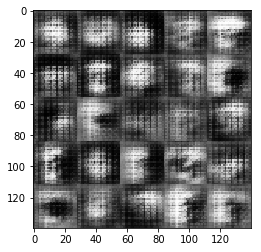

Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 1.0366
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 1.6950... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.7776


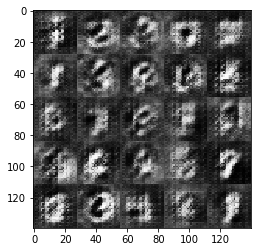

Epoch 1/2... Discriminator Loss: 1.6443... Generator Loss: 0.8595
Epoch 1/2... Discriminator Loss: 1.6904... Generator Loss: 0.7676
Epoch 1/2... Discriminator Loss: 1.6945... Generator Loss: 0.6760
Epoch 1/2... Discriminator Loss: 2.3233... Generator Loss: 0.7041


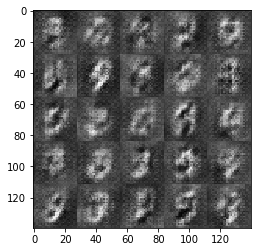

Epoch 1/2... Discriminator Loss: 1.4113... Generator Loss: 0.9691
Epoch 1/2... Discriminator Loss: 1.6062... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.6952
Epoch 1/2... Discriminator Loss: 1.6643... Generator Loss: 0.6899


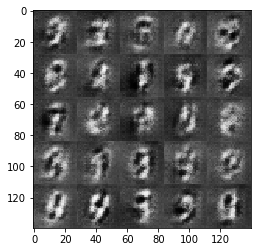

Epoch 1/2... Discriminator Loss: 1.7694... Generator Loss: 0.9059
Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 0.6538
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.6335
Epoch 1/2... Discriminator Loss: 1.6675... Generator Loss: 0.7996


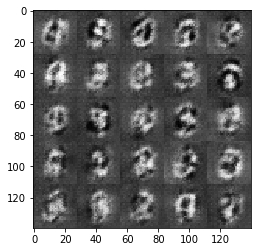

Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 1.4721... Generator Loss: 0.8365
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 0.5543
Epoch 1/2... Discriminator Loss: 1.6213... Generator Loss: 0.7423


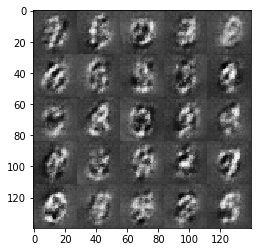

Epoch 1/2... Discriminator Loss: 1.2692... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 0.9780
Epoch 1/2... Discriminator Loss: 1.4921... Generator Loss: 1.0137
Epoch 1/2... Discriminator Loss: 1.5827... Generator Loss: 0.8800


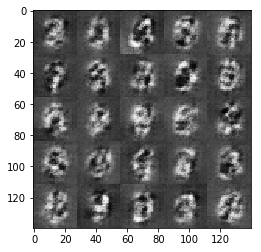

Epoch 1/2... Discriminator Loss: 2.0968... Generator Loss: 1.8570
Epoch 1/2... Discriminator Loss: 1.2145... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.6592
Epoch 1/2... Discriminator Loss: 1.5552... Generator Loss: 0.8015


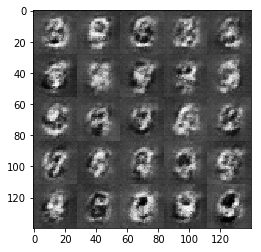

Epoch 1/2... Discriminator Loss: 1.2164... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 1.3546... Generator Loss: 0.5022
Epoch 1/2... Discriminator Loss: 1.5116... Generator Loss: 0.4219
Epoch 1/2... Discriminator Loss: 1.5865... Generator Loss: 0.9339


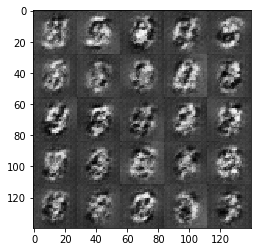

Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 1.5570... Generator Loss: 1.5420
Epoch 1/2... Discriminator Loss: 2.5964... Generator Loss: 2.2100
Epoch 1/2... Discriminator Loss: 1.2937... Generator Loss: 0.5789


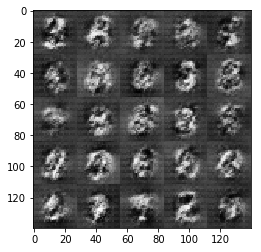

Epoch 1/2... Discriminator Loss: 1.6509... Generator Loss: 1.3790
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.8591
Epoch 1/2... Discriminator Loss: 1.8212... Generator Loss: 0.9439
Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 0.9640


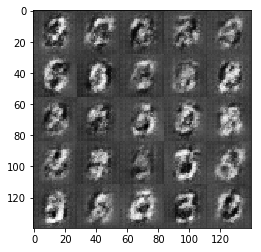

Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.8596
Epoch 1/2... Discriminator Loss: 1.4748... Generator Loss: 1.4020
Epoch 1/2... Discriminator Loss: 2.6820... Generator Loss: 1.6120
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.6776


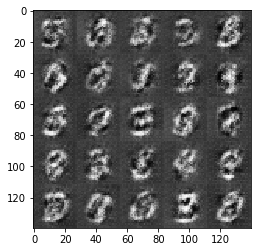

Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 2.5232... Generator Loss: 2.2336
Epoch 1/2... Discriminator Loss: 1.4797... Generator Loss: 1.2685
Epoch 1/2... Discriminator Loss: 1.7139... Generator Loss: 1.4775


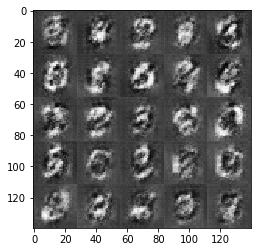

Epoch 1/2... Discriminator Loss: 1.5792... Generator Loss: 1.2616
Epoch 1/2... Discriminator Loss: 1.6558... Generator Loss: 0.7239
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.7320
Epoch 1/2... Discriminator Loss: 1.5633... Generator Loss: 1.5296


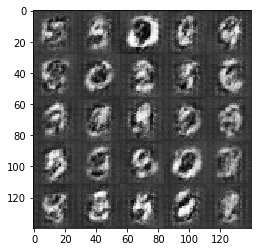

Epoch 1/2... Discriminator Loss: 1.4258... Generator Loss: 0.6693
Epoch 1/2... Discriminator Loss: 1.5951... Generator Loss: 1.2142
Epoch 1/2... Discriminator Loss: 1.8084... Generator Loss: 1.3745
Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 0.5588


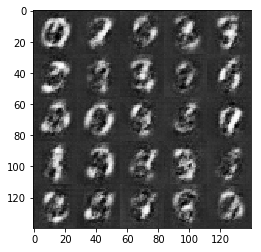

Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 0.7303
Epoch 1/2... Discriminator Loss: 1.4411... Generator Loss: 0.4994
Epoch 1/2... Discriminator Loss: 1.4725... Generator Loss: 1.0912
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.7449


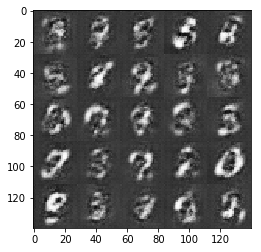

Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 1.8259... Generator Loss: 1.1915
Epoch 1/2... Discriminator Loss: 1.5560... Generator Loss: 1.3732
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.5586


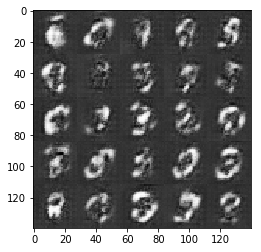

Epoch 1/2... Discriminator Loss: 1.7555... Generator Loss: 0.3544
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 1.6094
Epoch 1/2... Discriminator Loss: 1.5462... Generator Loss: 0.5951
Epoch 1/2... Discriminator Loss: 1.9100... Generator Loss: 1.2581


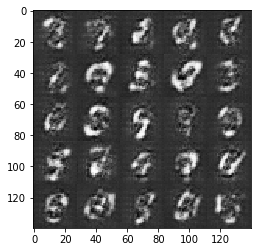

Epoch 1/2... Discriminator Loss: 1.4671... Generator Loss: 0.8134
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.7134
Epoch 1/2... Discriminator Loss: 1.8125... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.8453


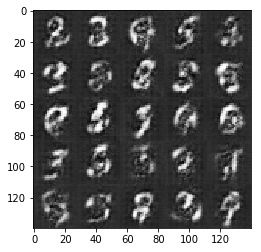

Epoch 2/2... Discriminator Loss: 1.4937... Generator Loss: 0.4800
Epoch 2/2... Discriminator Loss: 1.2921... Generator Loss: 0.6733
Epoch 2/2... Discriminator Loss: 2.4694... Generator Loss: 1.9342
Epoch 2/2... Discriminator Loss: 2.8787... Generator Loss: 2.1851


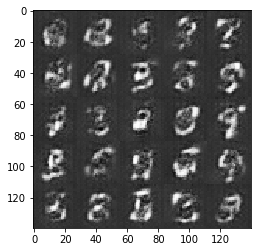

Epoch 2/2... Discriminator Loss: 2.5089... Generator Loss: 2.4575
Epoch 2/2... Discriminator Loss: 2.5255... Generator Loss: 2.4468
Epoch 2/2... Discriminator Loss: 1.8981... Generator Loss: 1.3867
Epoch 2/2... Discriminator Loss: 1.1894... Generator Loss: 0.7433


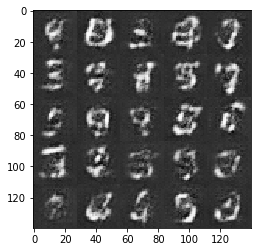

Epoch 2/2... Discriminator Loss: 2.2911... Generator Loss: 2.0697
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 0.7555
Epoch 2/2... Discriminator Loss: 1.8712... Generator Loss: 2.0836
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.6606


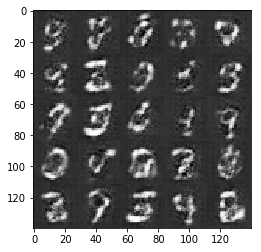

Epoch 2/2... Discriminator Loss: 1.7306... Generator Loss: 0.3418
Epoch 2/2... Discriminator Loss: 1.2333... Generator Loss: 0.9391
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.8557
Epoch 2/2... Discriminator Loss: 2.4945... Generator Loss: 2.6870


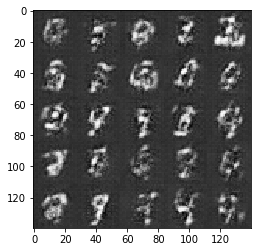

Epoch 2/2... Discriminator Loss: 3.7697... Generator Loss: 3.3440
Epoch 2/2... Discriminator Loss: 1.7042... Generator Loss: 0.4326
Epoch 2/2... Discriminator Loss: 1.3207... Generator Loss: 0.6963
Epoch 2/2... Discriminator Loss: 1.6057... Generator Loss: 1.3086


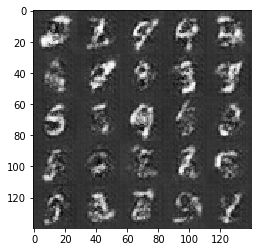

Epoch 2/2... Discriminator Loss: 1.4737... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 3.1767... Generator Loss: 2.5126
Epoch 2/2... Discriminator Loss: 1.5875... Generator Loss: 0.5134
Epoch 2/2... Discriminator Loss: 1.6308... Generator Loss: 0.8149


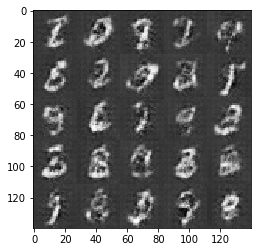

Epoch 2/2... Discriminator Loss: 2.6884... Generator Loss: 2.0848
Epoch 2/2... Discriminator Loss: 3.6108... Generator Loss: 2.3696
Epoch 2/2... Discriminator Loss: 2.1213... Generator Loss: 2.1297
Epoch 2/2... Discriminator Loss: 2.4443... Generator Loss: 2.8274


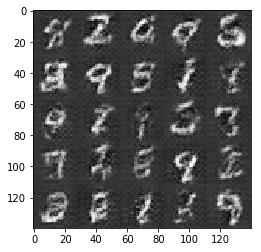

Epoch 2/2... Discriminator Loss: 2.7022... Generator Loss: 2.1876
Epoch 2/2... Discriminator Loss: 1.8057... Generator Loss: 1.3665
Epoch 2/2... Discriminator Loss: 1.5085... Generator Loss: 1.1690
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 1.8016


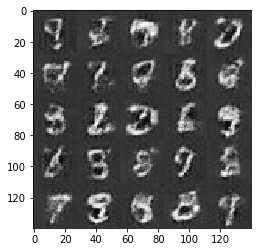

Epoch 2/2... Discriminator Loss: 2.2302... Generator Loss: 1.3964
Epoch 2/2... Discriminator Loss: 2.3813... Generator Loss: 1.9804
Epoch 2/2... Discriminator Loss: 4.4513... Generator Loss: 3.5938
Epoch 2/2... Discriminator Loss: 1.5062... Generator Loss: 0.7450


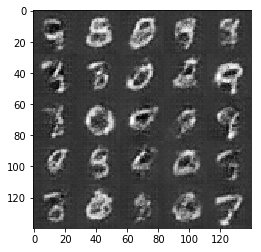

Epoch 2/2... Discriminator Loss: 1.9280... Generator Loss: 1.2308
Epoch 2/2... Discriminator Loss: 2.5543... Generator Loss: 1.3369
Epoch 2/2... Discriminator Loss: 1.5955... Generator Loss: 1.1936
Epoch 2/2... Discriminator Loss: 2.2541... Generator Loss: 1.8010


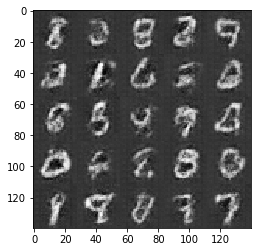

Epoch 2/2... Discriminator Loss: 3.0093... Generator Loss: 2.4883
Epoch 2/2... Discriminator Loss: 2.0325... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 1.8125... Generator Loss: 1.0233
Epoch 2/2... Discriminator Loss: 1.7920... Generator Loss: 0.7851


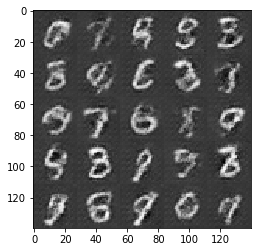

Epoch 2/2... Discriminator Loss: 3.2701... Generator Loss: 2.8477
Epoch 2/2... Discriminator Loss: 2.5145... Generator Loss: 1.8936
Epoch 2/2... Discriminator Loss: 3.2256... Generator Loss: 2.1902
Epoch 2/2... Discriminator Loss: 1.7867... Generator Loss: 0.8626


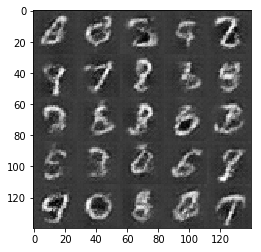

Epoch 2/2... Discriminator Loss: 3.3101... Generator Loss: 2.3541
Epoch 2/2... Discriminator Loss: 3.4224... Generator Loss: 2.4101
Epoch 2/2... Discriminator Loss: 2.9099... Generator Loss: 2.1913
Epoch 2/2... Discriminator Loss: 2.8317... Generator Loss: 1.8245


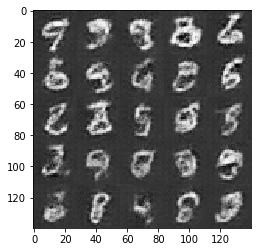

Epoch 2/2... Discriminator Loss: 3.0253... Generator Loss: 2.1617
Epoch 2/2... Discriminator Loss: 2.0559... Generator Loss: 0.9639
Epoch 2/2... Discriminator Loss: 2.5562... Generator Loss: 1.5374
Epoch 2/2... Discriminator Loss: 4.4707... Generator Loss: 2.1072


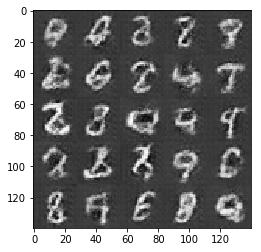

Epoch 2/2... Discriminator Loss: 2.3306... Generator Loss: 1.1394
Epoch 2/2... Discriminator Loss: 2.2476... Generator Loss: 0.5321
Epoch 2/2... Discriminator Loss: 4.0082... Generator Loss: 2.6511
Epoch 2/2... Discriminator Loss: 1.9665... Generator Loss: 0.7080


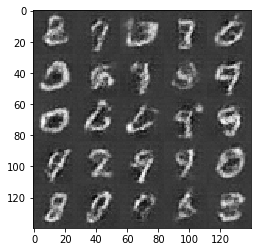

Epoch 2/2... Discriminator Loss: 2.0869... Generator Loss: 0.6290
Epoch 2/2... Discriminator Loss: 4.5318... Generator Loss: 3.1672
Epoch 2/2... Discriminator Loss: 3.2814... Generator Loss: 1.7520
Epoch 2/2... Discriminator Loss: 2.2845... Generator Loss: 0.7635


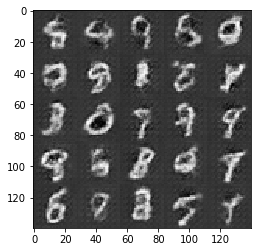

Epoch 2/2... Discriminator Loss: 4.8338... Generator Loss: 3.0241
Epoch 2/2... Discriminator Loss: 4.3987... Generator Loss: 2.8236
Epoch 2/2... Discriminator Loss: 2.1685... Generator Loss: 0.8950
Epoch 2/2... Discriminator Loss: 2.2853... Generator Loss: 1.6655


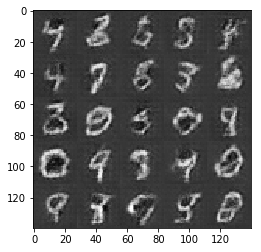

Epoch 2/2... Discriminator Loss: 3.4281... Generator Loss: 2.4571
Epoch 2/2... Discriminator Loss: 3.2643... Generator Loss: 1.1267
Epoch 2/2... Discriminator Loss: 4.7931... Generator Loss: 3.7394
Epoch 2/2... Discriminator Loss: 2.2505... Generator Loss: 1.0934


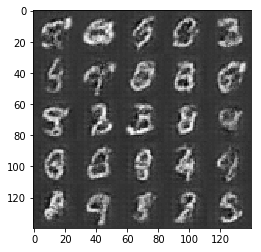

Epoch 2/2... Discriminator Loss: 3.1087... Generator Loss: 1.4056
Epoch 2/2... Discriminator Loss: 2.1071... Generator Loss: 1.2044


In [36]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.